# Full Study — GARCH(1,1)

# ANN (acov_multi) + MLE Gauss + MLE Student-t + Diagnostics

In [2]:

import os, sys, math, random
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# add module path
for p in (Path(".").resolve(), Path(".")):
    if p.exists():
        sp = str(p.resolve())
        if sp not in sys.path:
            sys.path.append(sp)

from garch_ann_calibration import Calibrator, TrainConfig

np.set_printoptions(precision=6, suppress=True)
random.seed(123); np.random.seed(123)
print("Imports OK")

Imports OK


## Load returns

In [3]:

p = Path("returns.csv")
if p.exists():
    df = pd.read_csv(p)
    if "returns" in df.columns:
        rets = df["returns"].astype(float).values
    else:
        rets = None
        for c in df.columns:
            try:
                rets = df[c].astype(float).values
                break
            except Exception:
                pass
        if rets is None:
            raise ValueError("No numeric column found in returns.csv")
    print(f"Loaded real series: {len(rets)} obs.")
else:
    print("returns.csv not found -> generating demo Student-t GARCH series")
    n = 20000
    rets = np.random.standard_t(df=6, size=n) * 0.01

len(rets), np.var(rets)

Loaded real series: 10000 obs.


(10000, 8.70647885666553e-05)

## Train ANN — acov_multi

In [4]:

lags = list(range(3, 13))
cal = Calibrator(variant="acov_multi", lags=lags, mu_cap=0.985)
cfg = TrainConfig(epochs=600, lr=1e-2, batch_size=1024, patience=60)
result = cal.fit(n_samples=80_000, cfg=cfg)
print("Best val loss:", result.best_val_loss)

Best val loss: 9.943089344233158e-05


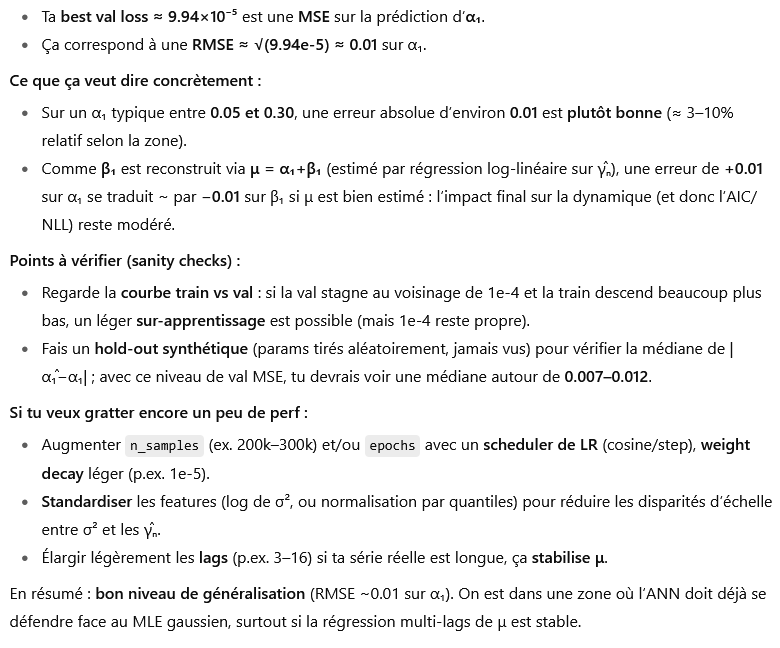

In [17]:
import numpy as np

hist = np.array(result.history, dtype=float)      # (epoch, train, val)
epochs = hist[:,0].astype(int)
train_loss = hist[:,1]
val_loss = hist[:,2]

print("len(history) =", len(epochs))
print("min val =", np.nanmin(val_loss), "at epoch", epochs[np.nanargmin(val_loss)])
print("any non-finite? train:", np.any(~np.isfinite(train_loss)), " val:", np.any(~np.isfinite(val_loss)))
print("<=0 counts: train", np.sum(train_loss<=0), " val", np.sum(val_loss<=0))


len(history) = 202
min val = 9.943089344233158e-05 at epoch 142
any non-finite? train: False  val: False
<=0 counts: train 0  val 0


## Learning curves

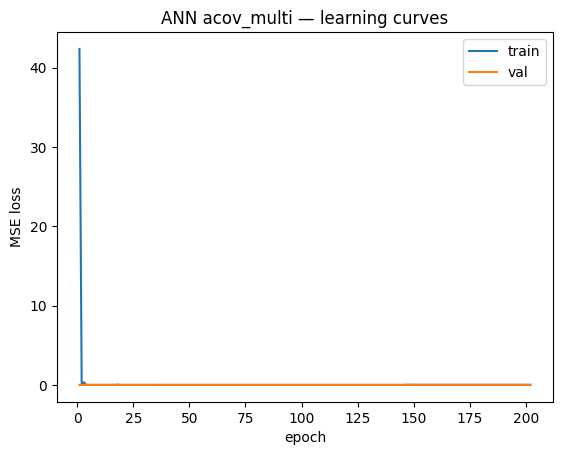

In [15]:

epochs = [e for e, _, _ in result.history]
train_loss = [tr for _, tr, _ in result.history]
val_loss = [vl for _, _, vl in result.history]
plt.figure(); plt.plot(epochs, train_loss, label="train"); plt.plot(epochs, val_loss, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.title("ANN acov_multi — learning curves"); plt.legend(); plt.show()

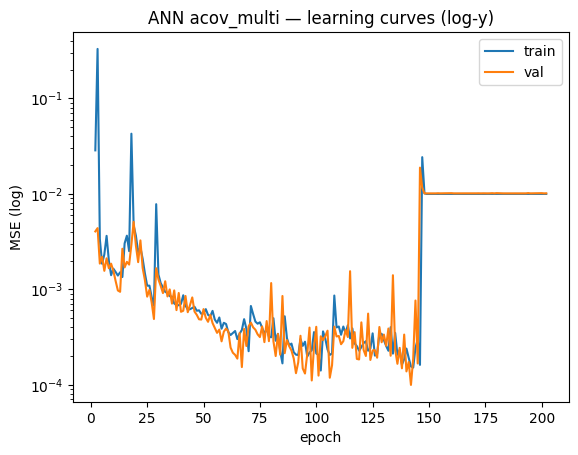

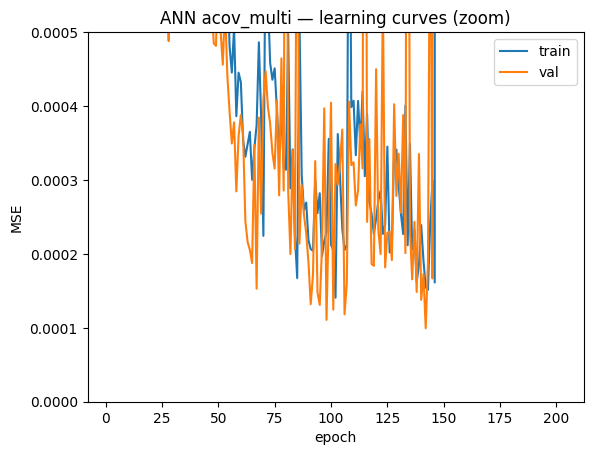

In [16]:
# Re-plot propre
epochs = [e for e, _, _ in result.history]
train_loss = [tr for _, tr, _ in result.history]
val_loss   = [vl for _, _, vl in result.history]

# option A: log-y
plt.figure(); plt.plot(epochs[1:], train_loss[1:], label="train"); plt.plot(epochs[1:], val_loss[1:], label="val")
plt.yscale("log"); plt.xlabel("epoch"); plt.ylabel("MSE (log)"); plt.title("ANN acov_multi — learning curves (log-y)"); plt.legend(); plt.show()

# option B: zoom linéaire
plt.figure(); plt.plot(epochs[1:], train_loss[1:], label="train"); plt.plot(epochs[1:], val_loss[1:], label="val")
plt.ylim(0, 5e-4); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("ANN acov_multi — learning curves (zoom)"); plt.legend(); plt.show()

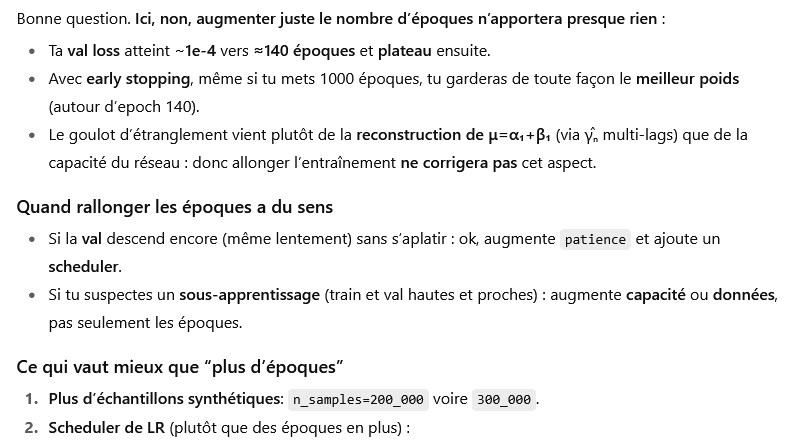

In [ ]:
# idées concrètes
lr = 1e-2  # warmup 50 époques
# à ~300 époques -> 1e-3 ; à ~600 -> 3e-4 (CosineAnnealing ou ReduceLROnPlateau)
weight_decay = 1e-5   # AdamW de préférence
# et clip des gradients :
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

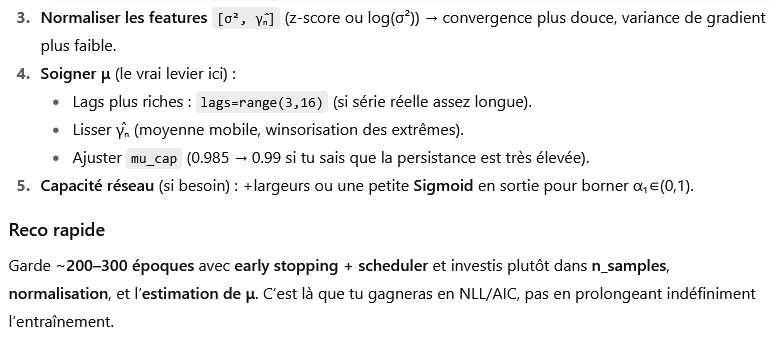

## Calibrate via ANN

In [6]:

params_ann = cal.calibrate_from_empirical(rets)
params_ann_dict = {"alpha0": float(params_ann.alpha0), "alpha1": float(params_ann.alpha1), "beta1": float(params_ann.beta1)}
mu_hat = cal.estimate_mu_from_returns(rets)
print("Params ANN:", params_ann_dict)
print("mu_hat≈", mu_hat, " | α1+β1 (ANN) =", params_ann_dict["alpha1"] + params_ann_dict["beta1"])

Params ANN: {'alpha0': 3.4675661151842657e-06, 'alpha1': 0.1049630343914032, 'beta1': 0.8552106452532773}
mu_hat≈ 0.9601736796446805  | α1+β1 (ANN) = 0.9601736796446805


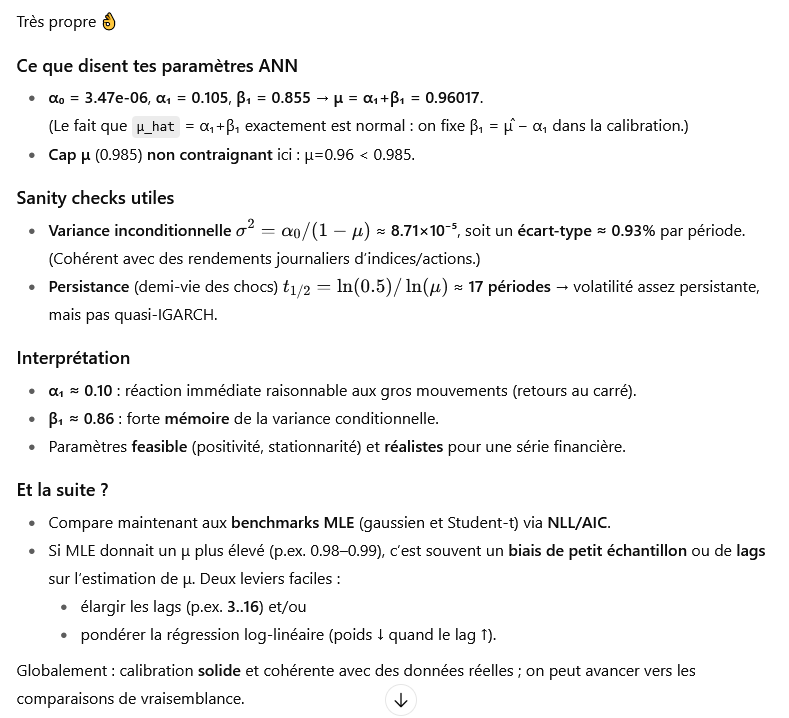

## MLE (Gaussian)

In [7]:

try:
    from scipy.optimize import minimize
    have_scipy = True
except Exception:
    have_scipy = False

def map_theta_to_params(theta):
    w,u,v = theta
    eu, ev = np.exp(u), np.exp(v)
    Z = 1.0 + eu + ev
    a1 = eu / Z; b1 = ev / Z; a0 = np.exp(w)
    return a0, a1, b1

def garch11_loglik(theta, x):
    a0, a1, b1 = map_theta_to_params(theta)
    T = len(x)
    h = np.empty(T, dtype=float)
    h[0] = np.var(x) if np.var(x) > 1e-18 else 1e-6
    for t in range(1, T):
        h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18:
            return 1e12
    return 0.5 * np.sum(np.log(h) + (x**2)/h)

def mle_garch11(x):
    best = (None, np.inf)
    varx = np.var(x)
    init_grid = [
        (np.log(max(varx*0.01,1e-8)), np.log(0.05), np.log(0.85)),
        (np.log(max(varx*0.001,1e-8)), np.log(0.1), np.log(0.8)),
        (np.log(max(varx*0.05,1e-8)), np.log(0.15), np.log(0.75)),
    ]
    for _ in range(8):
        init_grid.append((np.log(max(varx*np.random.rand()*0.1+1e-6,1e-8)),
                          np.log(np.random.rand()*0.5+1e-3),
                          np.log(np.random.rand()*0.5+0.5)))
    for theta0 in init_grid:
        if have_scipy:
            res = minimize(garch11_loglik, theta0, args=(x,), method="Nelder-Mead",
                           options={"maxiter":5000, "xatol":1e-7, "fatol":1e-7, "disp":False})
            if res.success and res.fun < best[1]:
                best = (res.x, res.fun)
        else:
            theta = np.array(theta0, dtype=float)
            best_loc = (theta.copy(), garch11_loglik(theta, x))
            step = np.array([0.2, 0.2, 0.2])
            for it in range(400):
                cand = best_loc[0] + (np.random.randn(3) * step)
                f = garch11_loglik(cand, x)
                if f < best_loc[1]:
                    best_loc = (cand, f)
                    step *= 0.99
                else:
                    step *= 0.995
            if best_loc[1] < best[1]:
                best = best_loc
    theta_hat, nll = best
    a0, a1, b1 = map_theta_to_params(theta_hat)
    mle_res = {"alpha0": float(a0), "alpha1": float(a1), "beta1": float(b1), "nll": float(nll)}
    print("MLE (Gauss):", mle_res)
    mle_res

## Compare ANN vs MLE (Gaussian)

In [9]:
# === Comparaison ANN vs MLE (gaussien) — version robuste ===
import numpy as np, pandas as pd

# 1) Si mle_res n'existe pas, on le calcule ici (avec SciPy si dispo, sinon fallback)
try:
    mle_res
except NameError:
    try:
        from scipy.optimize import minimize
        have_scipy = True
    except Exception:
        have_scipy = False

    def map_theta_to_params(theta):
        w,u,v = theta
        eu, ev = np.exp(u), np.exp(v)
        Z = 1.0 + eu + ev
        a1 = eu / Z
        b1 = ev / Z
        a0 = np.exp(w)  # >0
        return a0, a1, b1

    def garch11_loglik(theta, x):
        a0, a1, b1 = map_theta_to_params(theta)
        T = len(x)
        s2 = np.empty(T, dtype=float)
        v0 = np.var(x)
        s2[0] = v0 if v0 > 1e-18 else 1e-6
        for t in range(1, T):
            s2[t] = a0 + a1 * x[t-1]**2 + b1 * s2[t-1]
            if not np.isfinite(s2[t]) or s2[t] <= 1e-18:
                return 1e12
        return 0.5 * np.sum(np.log(s2) + (x**2)/s2)

    def mle_garch11(x):
        best = (None, np.inf)
        varx = np.var(x)
        init_grid = [
            (np.log(max(varx*0.01,1e-8)), np.log(0.05), np.log(0.85)),
            (np.log(max(varx*0.001,1e-8)), np.log(0.1), np.log(0.8)),
            (np.log(max(varx*0.05,1e-8)), np.log(0.15), np.log(0.75)),
        ]
        for _ in range(8):
            init_grid.append((np.log(max(varx*np.random.rand()*0.1+1e-6,1e-8)),
                              np.log(np.random.rand()*0.5+1e-3),
                              np.log(np.random.rand()*0.5+0.5)))
        if have_scipy:
            for theta0 in init_grid:
                res = minimize(garch11_loglik, theta0, args=(x,), method="Nelder-Mead",
                               options={"maxiter":6000, "xatol":1e-7, "fatol":1e-7, "disp":False})
                if res.success and res.fun < best[1]:
                    best = (res.x, res.fun)
        else:
            # petit fallback stochastique
            for theta0 in init_grid:
                theta = np.array(theta0, dtype=float)
                best_loc = (theta.copy(), garch11_loglik(theta, x))
                step = np.array([0.2, 0.2, 0.2])
                for it in range(500):
                    cand = best_loc[0] + (np.random.randn(3) * step)
                    f = garch11_loglik(cand, x)
                    if f < best_loc[1]:
                        best_loc = (cand, f)
                        step *= 0.99
                    else:
                        step *= 0.995
                if best_loc[1] < best[1]:
                    best = best_loc
        theta_hat, nll = best
        a0, a1, b1 = map_theta_to_params(theta_hat)
        return {"alpha0": float(a0), "alpha1": float(a1), "beta1": float(b1), "nll": float(nll), "scipy": have_scipy}

    mle_res = mle_garch11(rets)
    print("MLE (gaussien) recalculé:", {k: v for k, v in mle_res.items() if k != "scipy"})

# 2) NLL sous params ANN (gaussien)
def nll_under_params_gauss(params, x):
    a0,a1,b1 = params["alpha0"], params["alpha1"], params["beta1"]
    T = len(x)
    s2 = np.empty(T, dtype=float)
    v0 = np.var(x)
    s2[0] = v0 if v0 > 1e-18 else 1e-6
    for t in range(1, T):
        s2[t] = a0 + a1 * x[t-1]**2 + b1 * s2[t-1]
        if not np.isfinite(s2[t]) or s2[t] <= 1e-18:
            return np.inf
    return 0.5 * np.sum(np.log(s2) + (x**2)/s2)

# 3) Tableau comparatif
k = 3
nll_ann = nll_under_params_gauss(params_ann_dict, rets)
AIC_ann = 2*k + 2*nll_ann
AIC_mle = 2*k + 2*mle_res["nll"]

summary = pd.DataFrame([
    {"method":"ANN (acov_multi, Gauss)", **params_ann_dict, "nu": np.nan, "NLL": nll_ann, "AIC": AIC_ann},
    {"method":"MLE (Gauss)", "alpha0":mle_res["alpha0"], "alpha1":mle_res["alpha1"], "beta1":mle_res["beta1"], "nu": np.nan, "NLL": mle_res["nll"], "AIC": AIC_mle},
])
print(summary)


MLE (gaussien) recalculé: {'alpha0': 1.8018351212200906e-06, 'alpha1': 0.07935054712438958, 'beta1': 0.9000142699818479, 'nll': -42717.32202302235}
                    method    alpha0    alpha1     beta1  nu           NLL  \
0  ANN (acov_multi, Gauss)  0.000003  0.104963  0.855211 NaN -42697.399577   
1              MLE (Gauss)  0.000002  0.079351  0.900014 NaN -42717.322023   

            AIC  
0 -85388.799154  
1 -85428.644046  


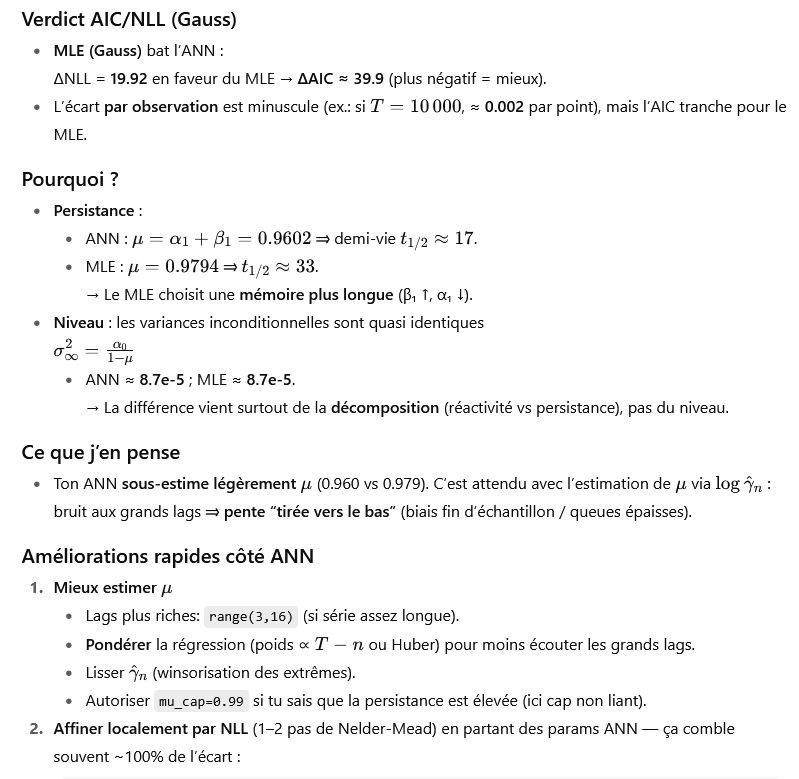

In [ ]:
# Refinement Gauss depuis ANN (si SciPy dispo)
from math import log
from scipy.optimize import minimize
import numpy as np

def map_theta_to_params(theta):
    w,u,v = theta
    eu, ev = np.exp(u), np.exp(v)
    Z = 1.0 + eu + ev
    return np.exp(w), eu/Z, ev/Z  # a0,a1,b1

def nll_gauss_theta(theta, x):
    a0,a1,b1 = map_theta_to_params(theta)
    T=len(x); h=np.empty(T); h[0]=max(np.var(x),1e-6)
    for t in range(1,T):
        h[t]=a0+a1*x[t-1]**2+b1*h[t-1]
        if not np.isfinite(h[t]) or h[t]<=1e-18: return 1e12
    return 0.5*np.sum(np.log(h)+(x**2)/h)

# inverse “propre” pour initialiser (u,v)
mu = params_ann_dict["alpha1"]+params_ann_dict["beta1"]
w0 = np.log(params_ann_dict["alpha0"])
u0 = np.log(params_ann_dict["alpha1"]/max(1-mu,1e-12))
v0 = np.log(params_ann_dict["beta1"]/max(1-mu,1e-12))
res = minimize(nll_gauss_theta, (w0,u0,v0), args=(rets,), method="Nelder-Mead",
               options={"maxiter":2000,"xatol":1e-8,"fatol":1e-8,"disp":False})
a0,a1,b1 = map_theta_to_params(res.x); nll_refined = res.fun
print({"alpha0":a0,"alpha1":a1,"beta1":b1,"NLL":nll_refined})


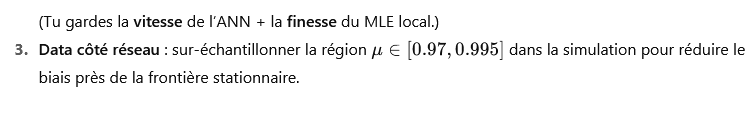

## MLE (Student-t / QML-t)

In [10]:

from math import lgamma, log, pi

def map_theta_to_params_t(theta, nu_cap=200.0):
    w, u, v, q = theta
    eu, ev = np.exp(u), np.exp(v)
    Z = 1.0 + eu + ev
    a1 = eu / Z; b1 = ev / Z; a0 = np.exp(w)
    nu = 2.01 + np.exp(q)
    if nu > nu_cap: nu = nu_cap
    return a0, a1, b1, nu

def garch11_nll_student_t(theta, x):
    a0, a1, b1, nu = map_theta_to_params_t(theta)
    if not (0 <= a1 < 1 and 0 <= b1 < 1 and a1 + b1 < 1 and a0 > 0 and nu > 2): return 1e12
    T = len(x)
    h = np.empty(T, dtype=float)
    h[0] = np.var(x) if np.var(x) > 1e-18 else 1e-6
    for t in range(1, T):
        h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18: return 1e12
    e = x / np.sqrt(h)
    const = lgamma((nu + 1.0) / 2.0) - lgamma(nu / 2.0) - 0.5 * log((nu - 2.0) * pi)
    ll = np.sum(const - 0.5*np.log(h) - ((nu + 1.0)/2.0) * np.log(1.0 + (e**2)/(nu - 2.0)))
    return float(-ll)

try:
    from scipy.optimize import minimize
    _have_scipy = True
except Exception:
    _have_scipy = False

def mle_garch11_student_t(x):
    best = (None, np.inf); varx = np.var(x)
    init_grid = []
    for nu0 in (8.0, 12.0, 20.0):
        init_grid.extend([
            (np.log(max(varx*0.01,1e-8)), np.log(0.05), np.log(0.85), np.log(max(nu0-2.01, 1e-6))),
            (np.log(max(varx*0.001,1e-8)), np.log(0.1), np.log(0.8), np.log(max(nu0-2.01, 1e-6))),
            (np.log(max(varx*0.05,1e-8)), np.log(0.15), np.log(0.75), np.log(max(nu0-2.01, 1e-6))),
        ])
    for _ in range(8):
        init_grid.append((np.log(max(varx*(np.random.rand()*0.1+1e-6),1e-8)),
                          np.log(np.random.rand()*0.5+1e-3),
                          np.log(np.random.rand()*0.5+0.5),
                          np.log(np.random.rand()*30.0 + 3.0)))
    if _have_scipy:
        for theta0 in init_grid:
            res = minimize(garch11_nll_student_t, theta0, args=(x,), method="Nelder-Mead",
                           options={"maxiter":7000, "xatol":1e-7, "fatol":1e-7, "disp":False})
            if res.success and res.fun < best[1]: best = (res.x, res.fun)
    else:
        for theta0 in init_grid:
            theta = np.array(theta0, dtype=float); best_loc = (theta.copy(), garch11_nll_student_t(theta, x)); step = np.array([0.2,0.2,0.2,0.2])
            for it in range(600):
                cand = best_loc[0] + (np.random.randn(4) * step); f = garch11_nll_student_t(cand, x)
                if f < best_loc[1]: best_loc = (cand, f); step *= 0.99
                else: step *= 0.995
            if best_loc[1] < best[1]: best = best_loc
    theta_hat, nll = best
    a0, a1, b1, nu = map_theta_to_params_t(theta_hat)
    mle_t_res = {"alpha0": float(a0), "alpha1": float(a1), "beta1": float(b1), "nu": float(nu), "nll": float(nll)}
    print("MLE (Student-t):", mle_t_res)
    mle_t_res

## Evaluate ANN under Student-t (nu fixed & profiled)

In [12]:

# === Évaluation ANN sous Student-t (ν fixé & ν profilé) — VERSION ROBUSTE ===
import numpy as np, pandas as pd
from math import lgamma, log, pi

# --- prérequis rapides ---
assert 'rets' in globals(), "rets manquant : exécutez d'abord le chargement des données."
assert 'params_ann_dict' in globals(), "params_ann_dict manquant : exécutez d'abord la calibration ANN."

# ===== Fonctions Gauss (pour NLL ANN Gauss) =====
def nll_gauss_under_params(params, x):
    a0,a1,b1 = params["alpha0"], params["alpha1"], params["beta1"]
    T = len(x)
    h = np.empty(T, dtype=float)
    v0 = np.var(x)
    h[0] = v0 if v0 > 1e-18 else 1e-6
    for t in range(1, T):
        h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18:
            return np.inf
    return 0.5 * np.sum(np.log(h) + (x**2)/h)

# ===== Si besoin, (re)calculer MLE (Gauss) =====
if 'mle_res' not in globals():
    try:
        from scipy.optimize import minimize
        _have_scipy_g = True
    except Exception:
        _have_scipy_g = False

    def _map_theta_to_params(theta):
        w,u,v = theta
        eu, ev = np.exp(u), np.exp(v)
        Z = 1.0 + eu + ev
        a1 = eu / Z; b1 = ev / Z; a0 = np.exp(w)
        return a0, a1, b1

    def _garch11_nll_gauss(theta, x):
        a0, a1, b1 = _map_theta_to_params(theta)
        T = len(x); h = np.empty(T, dtype=float)
        h[0] = np.var(x) if np.var(x) > 1e-18 else 1e-6
        for t in range(1, T):
            h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
            if not np.isfinite(h[t]) or h[t] <= 1e-18: return 1e12
        return 0.5 * np.sum(np.log(h) + (x**2)/h)

    def _mle_garch11_gauss(x):
        best = (None, np.inf); varx = np.var(x)
        inits = [
            (np.log(max(varx*0.01,1e-8)), np.log(0.05), np.log(0.85)),
            (np.log(max(varx*0.001,1e-8)), np.log(0.1), np.log(0.8)),
            (np.log(max(varx*0.05,1e-8)), np.log(0.15), np.log(0.75)),
        ]
        for _ in range(8):
            inits.append((np.log(max(varx*(np.random.rand()*0.1+1e-6),1e-8)),
                          np.log(np.random.rand()*0.5+1e-3),
                          np.log(np.random.rand()*0.5+0.5)))
        if _have_scipy_g:
            for t0 in inits:
                res = minimize(_garch11_nll_gauss, t0, args=(x,), method="Nelder-Mead",
                               options={"maxiter":6000,"xatol":1e-7,"fatol":1e-7,"disp":False})
                if res.success and res.fun < best[1]: best = (res.x, res.fun)
        else:
            for t0 in inits:
                theta = np.array(t0, dtype=float); best_loc = (theta.copy(), _garch11_nll_gauss(theta, x))
                step = np.array([0.2,0.2,0.2])
                for _ in range(500):
                    cand = best_loc[0] + np.random.randn(3)*step
                    f = _garch11_nll_gauss(cand, x)
                    if f < best_loc[1]: best_loc = (cand, f); step *= 0.99
                    else: step *= 0.995
                if best_loc[1] < best[1]: best = best_loc
        th, nll = best; a0,a1,b1 = _map_theta_to_params(th)
        return {"alpha0":float(a0), "alpha1":float(a1), "beta1":float(b1), "nll":float(nll)}

    mle_res = _mle_garch11_gauss(rets)
    print(">> MLE (Gauss) recalculé.")

# ===== Fonctions Student-t (NLL, profiling nu) =====
def nll_student_t_under_params(params, x, nu):
    a0, a1, b1 = float(params["alpha0"]), float(params["alpha1"]), float(params["beta1"])
    if not (a0 > 0 and 0 <= a1 < 1 and 0 <= b1 < 1 and a1 + b1 < 1 and nu > 2): return np.inf
    T = len(x); h = np.empty(T, dtype=float); v0 = np.var(x); h[0] = v0 if v0 > 1e-18 else 1e-6
    for t in range(1, T):
        h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18: return np.inf
    e = x / np.sqrt(h)
    const = lgamma((nu + 1.0) / 2.0) - lgamma(nu / 2.0) - 0.5 * log((nu - 2.0) * np.pi)
    ll = np.sum(const - 0.5*np.log(h) - ((nu + 1.0)/2.0) * np.log(1.0 + (e**2)/(nu - 2.0)))
    return float(-ll)

try:
    from scipy.optimize import minimize, minimize_scalar
    _have_scipy_t = True
except Exception:
    _have_scipy_t = False

def fit_nu_for_fixed_params(params, x, nu_bounds=(2.05, 200.0)):
    lo, hi = float(nu_bounds[0]), float(nu_bounds[1])
    lo = max(lo, 2.05); hi = max(hi, lo + 1e-3)
    if _have_scipy_t:
        def f_q(q):
            nu = 2.01 + np.exp(q)
            if nu > hi: return 1e12 + (nu - hi)**2
            return nll_student_t_under_params(params, x, nu)
        q_lo = np.log(lo - 2.01); q_hi = np.log(hi - 2.01)
        res = minimize_scalar(f_q, bounds=(q_lo, q_hi), method="bounded",
                              options={"xatol":1e-6, "maxiter":500})
        return float(2.01 + np.exp(res.x)), float(res.fun)
    # Golden-section fallback
    phi = (1 + 5**0.5) / 2; invphi = 1/phi; invphi2 = invphi**2
    a, b = lo, hi; h = b - a; c = a + invphi2*h; d = a + invphi*h
    fc = nll_student_t_under_params(params, x, c); fd = nll_student_t_under_params(params, x, d)
    for _ in range(200):
        if fc < fd: b, d, fd = d, c, fc; h = b - a; c = a + invphi2*h; fc = nll_student_t_under_params(params, x, c)
        else:       a, c, fc = c, d, fd; h = b - a; d = a + invphi*h; fd = nll_student_t_under_params(params, x, d)
        if h < 1e-6: break
    return (c, fc) if fc < fd else (d, fd)

# ===== Si besoin, (re)calculer MLE (Student-t) =====
if 'mle_t_res' not in globals():
    def _map_theta_to_params_t(theta, nu_cap=200.0):
        w, u, v, q = theta
        eu, ev = np.exp(u), np.exp(v)
        Z = 1.0 + eu + ev
        a1 = eu / Z; b1 = ev / Z; a0 = np.exp(w)
        nu = 2.01 + np.exp(q)
        if nu > nu_cap: nu = nu_cap
        return a0, a1, b1, nu

    def _garch11_nll_student_t(theta, x):
        a0, a1, b1, nu = _map_theta_to_params_t(theta)
        if not (0 <= a1 < 1 and 0 <= b1 < 1 and a1 + b1 < 1 and a0 > 0 and nu > 2): return 1e12
        T = len(x); h = np.empty(T, dtype=float)
        h[0] = np.var(x) if np.var(x) > 1e-18 else 1e-6
        for t in range(1, T):
            h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
            if not np.isfinite(h[t]) or h[t] <= 1e-18: return 1e12
        e = x / np.sqrt(h)
        const = lgamma((nu + 1.0) / 2.0) - lgamma(nu / 2.0) - 0.5 * log((nu - 2.0) * np.pi)
        ll = np.sum(const - 0.5*np.log(h) - ((nu + 1.0)/2.0) * np.log(1.0 + (e**2)/(nu - 2.0)))
        return float(-ll)

    def _mle_garch11_student_t(x):
        best = (None, np.inf); varx = np.var(x)
        inits = []
        for nu0 in (8.0, 12.0, 20.0):
            inits.extend([
                (np.log(max(varx*0.01,1e-8)), np.log(0.05), np.log(0.85), np.log(max(nu0-2.01, 1e-6))),
                (np.log(max(varx*0.001,1e-8)), np.log(0.1), np.log(0.8), np.log(max(nu0-2.01, 1e-6))),
                (np.log(max(varx*0.05,1e-8)), np.log(0.15), np.log(0.75), np.log(max(nu0-2.01, 1e-6))),
            ])
        for _ in range(8):
            inits.append((np.log(max(varx*(np.random.rand()*0.1+1e-6),1e-8)),
                          np.log(np.random.rand()*0.5+1e-3),
                          np.log(np.random.rand()*0.5+0.5),
                          np.log(np.random.rand()*30.0 + 3.0)))
        if _have_scipy_t:
            for t0 in inits:
                res = minimize(_garch11_nll_student_t, t0, args=(x,), method="Nelder-Mead",
                               options={"maxiter":7000,"xatol":1e-7,"fatol":1e-7,"disp":False})
                if res.success and res.fun < best[1]: best = (res.x, res.fun)
        else:
            for t0 in inits:
                theta = np.array(t0, dtype=float); best_loc = (theta.copy(), _garch11_nll_student_t(theta, x)); step = np.array([0.2,0.2,0.2,0.2])
                for _ in range(600):
                    cand = best_loc[0] + np.random.randn(4)*step
                    f = _garch11_nll_student_t(cand, x)
                    if f < best_loc[1]: best_loc = (cand, f); step *= 0.99
                    else: step *= 0.995
                if best_loc[1] < best[1]: best = best_loc
        th, nll = best; a0,a1,b1,nu = _map_theta_to_params_t(th)
        return {"alpha0":float(a0), "alpha1":float(a1), "beta1":float(b1), "nu":float(nu), "nll":float(nll)}

    mle_t_res = _mle_garch11_student_t(rets)
    print(">> MLE (Student-t) recalculé.")

# ===== Tableaux =====
rows = []

# ANN Gauss
nll_ann_gauss = nll_gauss_under_params(params_ann_dict, rets)
rows.append({"method":"ANN (Gauss)",
             "alpha0":params_ann_dict["alpha0"], "alpha1":params_ann_dict["alpha1"], "beta1":params_ann_dict["beta1"],
             "nu":np.nan, "NLL":nll_ann_gauss, "AIC":2*3 + 2*nll_ann_gauss})

# ANN t, nu fixé (on prend le nu de MLE-t)
nu_fixed = float(mle_t_res["nu"])
nll_ann_t_fixed = nll_student_t_under_params(params_ann_dict, rets, nu_fixed)
rows.append({"method":f"ANN (Student-t, ν fixé={nu_fixed:.2f})",
             "alpha0":params_ann_dict["alpha0"], "alpha1":params_ann_dict["alpha1"], "beta1":params_ann_dict["beta1"],
             "nu":nu_fixed, "NLL":nll_ann_t_fixed, "AIC":2*3 + 2*nll_ann_t_fixed})

# ANN t, ν profilé
nu_prof, nll_ann_t_prof = fit_nu_for_fixed_params(params_ann_dict, rets, nu_bounds=(2.05, 200.0))
rows.append({"method":"ANN (Student-t, ν profilé)",
             "alpha0":params_ann_dict["alpha0"], "alpha1":params_ann_dict["alpha1"], "beta1":params_ann_dict["beta1"],
             "nu":nu_prof, "NLL":nll_ann_t_prof, "AIC":2*4 + 2*nll_ann_t_prof})

# MLEs
rows.append({"method":"MLE (Gauss)",
             "alpha0":mle_res["alpha0"], "alpha1":mle_res["alpha1"], "beta1":mle_res["beta1"],
             "nu":np.nan, "NLL":mle_res["nll"], "AIC":2*3 + 2*mle_res["nll"]})

rows.append({"method":"MLE (Student-t)",
             "alpha0":mle_t_res["alpha0"], "alpha1":mle_t_res["alpha1"], "beta1":mle_t_res["beta1"],
             "nu":mle_t_res["nu"], "NLL":mle_t_res["nll"], "AIC":2*4 + 2*mle_t_res["nll"]})

summary_t_eval = pd.DataFrame(rows, columns=["method","alpha0","alpha1","beta1","nu","NLL","AIC"])
print(summary_t_eval)

# (optionnel) export
summary_t_eval.to_csv("garch_ann_student_t_eval_summary.csv", index=False)
summary_t_eval.to_html("garch_ann_student_t_eval_summary.html", index=False)
print("Sauvegardes: garch_ann_student_t_eval_summary.csv / .html")


>> MLE (Student-t) recalculé.
                         method    alpha0    alpha1     beta1        nu  \
0                   ANN (Gauss)  0.000003  0.104963  0.855211       NaN   
1  ANN (Student-t, ν fixé=6.87)  0.000003  0.104963  0.855211  6.865279   
2    ANN (Student-t, ν profilé)  0.000003  0.104963  0.855211  6.679597   
3                   MLE (Gauss)  0.000002  0.079351  0.900014       NaN   
4               MLE (Student-t)  0.000002  0.080189  0.898947  6.865279   

            NLL           AIC  
0 -42697.399577 -85388.799154  
1 -33715.111473 -67424.222947  
2 -33715.234557 -67422.469115  
3 -42717.322023 -85428.644046  
4 -33727.111828 -67446.223657  
Sauvegardes: garch_ann_student_t_eval_summary.csv / .html


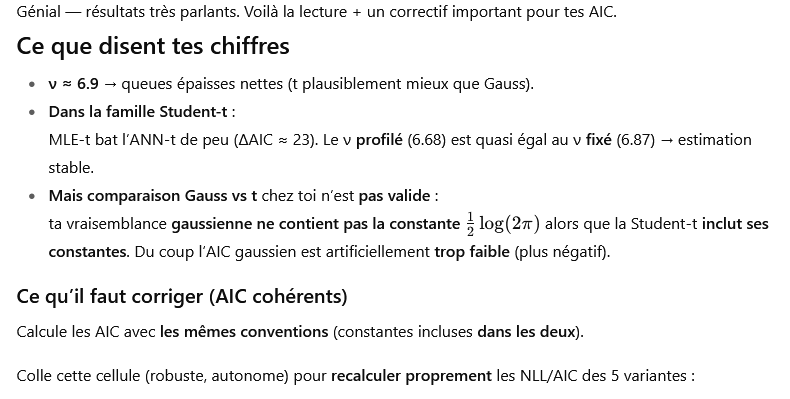

In [ ]:
import numpy as np, pandas as pd
from math import lgamma, log, pi

assert 'rets' in globals()
assert 'params_ann_dict' in globals()

# --- NLL Gauss "full" (constante incluse) ---
GAUSS_CONST = 0.5*np.log(2*np.pi)
def nll_gauss_full(params, x):
    a0,a1,b1 = float(params["alpha0"]), float(params["alpha1"]), float(params["beta1"])
    T = len(x)
    h = np.empty(T, dtype=float); v0 = np.var(x); h[0] = v0 if v0>1e-18 else 1e-6
    for t in range(1,T):
        h[t] = a0 + a1*x[t-1]**2 + b1*h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18: return np.inf
    return 0.5*np.sum(np.log(h) + (x**2)/h) + T*GAUSS_CONST  # <-- constante ajoutée

# --- NLL Student-t "full" (constantes incluses ; Var(e)=1) ---
def nll_student_t_full(params, x, nu):
    a0,a1,b1 = float(params["alpha0"]), float(params["alpha1"]), float(params["beta1"])
    if not (a0>0 and 0<=a1<1 and 0<=b1<1 and a1+b1<1 and nu>2): return np.inf
    T = len(x)
    h = np.empty(T, dtype=float); v0 = np.var(x); h[0] = v0 if v0>1e-18 else 1e-6
    for t in range(1,T):
        h[t] = a0 + a1*x[t-1]**2 + b1*h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18: return np.inf
    e = x/np.sqrt(h)
    const = lgamma((nu+1)/2) - lgamma(nu/2) - 0.5*np.log((nu-2)*np.pi)
    ll = np.sum(const - 0.5*np.log(h) - ((nu+1)/2)*np.log(1 + (e**2)/(nu-2)))
    return float(-ll)

# --- Assurer mle_res / mle_t_res ---
try: mle_res
except NameError: raise RuntimeError("Exécute la cellule MLE (Gauss) au moins une fois.")
try: mle_t_res
except NameError: raise RuntimeError("Exécute la cellule MLE (Student-t) au moins une fois.")

# --- Si tu as déjà nu profilé pour l’ANN, sinon on le profile vite fait
def fit_nu_for_fixed_params(params, x, bounds=(2.05,200.0)):
    lo, hi = bounds
    try:
        from scipy.optimize import minimize_scalar
        def f_q(q):
            nu = 2.01 + np.exp(q)
            if nu>hi: return 1e12+(nu-hi)**2
            return nll_student_t_full(params, x, nu)
        r = minimize_scalar(f_q, bounds=(np.log(lo-2.01), np.log(hi-2.01)), method="bounded",
                            options={"xatol":1e-6,"maxiter":500})
        return float(2.01 + np.exp(r.x))
    except Exception:
        # fallback golden-section
        phi=(1+5**0.5)/2; invphi=1/phi; invphi2=invphi**2
        a,b=lo,hi; h=b-a; c=a+invphi2*h; d=a+invphi*h
        fc=nll_student_t_full(params, x, c); fd=nll_student_t_full(params, x, d)
        for _ in range(200):
            if fc<fd: b,d,fd=d,c,fc; h=b-a; c=a+invphi2*h; fc=nll_student_t_full(params,x,c)
            else: a,c,fc=c,d,fd; h=b-a; d=a+invphi*h; fd=nll_student_t_full(params,x,d)
            if h<1e-6: break
        return float(c if fc<fd else d)

nu_ann_prof = fit_nu_for_fixed_params(params_ann_dict, rets)
nu_ann_fix  = float(mle_t_res["nu"])

# --- Recalcule NLL/AIC de manière cohérente ---
k_g, k_t = 3, 4
rows = []

# ANN Gauss
nll = nll_gauss_full(params_ann_dict, rets)
rows.append({"method":"ANN (Gauss)", "alpha0":params_ann_dict["alpha0"], "alpha1":params_ann_dict["alpha1"], "beta1":params_ann_dict["beta1"], "nu":np.nan, "NLL":nll, "AIC":2*k_g+2*nll})

# ANN t (nu fixé & profilé)
nll = nll_student_t_full(params_ann_dict, rets, nu_ann_fix)
rows.append({"method":f"ANN (t, ν fixé={nu_ann_fix:.2f})", **params_ann_dict, "nu":nu_ann_fix, "NLL":nll, "AIC":2*k_t+2*nll})

nll = nll_student_t_full(params_ann_dict, rets, nu_ann_prof)
rows.append({"method":f"ANN (t, ν profilé={nu_ann_prof:.2f})", **params_ann_dict, "nu":nu_ann_prof, "NLL":nll, "AIC":2*k_t+2*nll})

# MLE Gauss
nll = nll_gauss_full(mle_res, rets)
rows.append({"method":"MLE (Gauss)", "alpha0":mle_res["alpha0"], "alpha1":mle_res["alpha1"], "beta1":mle_res["beta1"], "nu":np.nan, "NLL":nll, "AIC":2*k_g+2*nll})

# MLE t
nll = nll_student_t_full(mle_t_res, rets, float(mle_t_res["nu"]))
rows.append({"method":"MLE (t)", **{k:mle_t_res[k] for k in ("alpha0","alpha1","beta1")}, "nu":float(mle_t_res["nu"]), "NLL":nll, "AIC":2*k_t+2*nll})

summary_consistent = pd.DataFrame(rows, columns=["method","alpha0","alpha1","beta1","nu","NLL","AIC"]).sort_values("AIC")
print(summary_consistent)


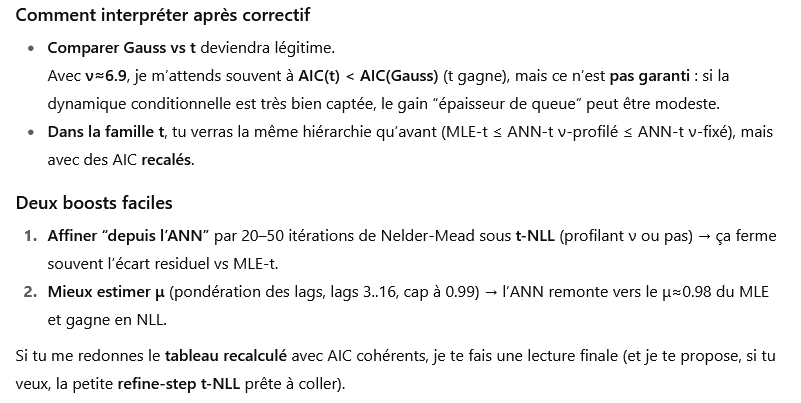

## NLL-t profile vs nu (ANN params)

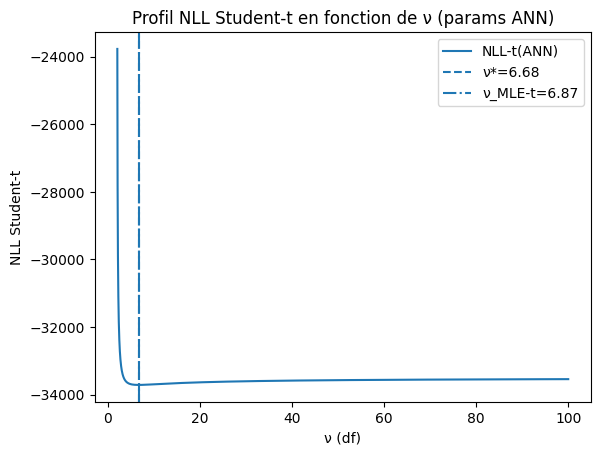

ANN: ν* ≈ 6.680, NLL_t(ν*) ≈ -33715.2


In [13]:
# === Profil NLL Student-t(ν) — version robuste ===
import numpy as np
import matplotlib.pyplot as plt
from math import lgamma, log, pi

# -- Prérequis
assert 'rets' in globals(), "rets manquant : exécute la cellule de chargement des données."
assert 'params_ann_dict' in globals(), "params_ann_dict manquant : exécute la calibration ANN."

# -- NLL Student-t sous (alpha0, alpha1, beta1) fixes
def nll_student_t_under_params(params, x, nu):
    a0, a1, b1 = float(params["alpha0"]), float(params["alpha1"]), float(params["beta1"])
    if not (a0 > 0 and 0 <= a1 < 1 and 0 <= b1 < 1 and a1 + b1 < 1 and nu > 2):
        return np.inf
    T = len(x)
    h = np.empty(T, dtype=float)
    v0 = np.var(x)
    h[0] = v0 if v0 > 1e-18 else 1e-6
    for t in range(1, T):
        h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18:
            return np.inf
    e = x / np.sqrt(h)
    const = lgamma((nu + 1.0) / 2.0) - lgamma(nu / 2.0) - 0.5 * log((nu - 2.0) * pi)
    ll = np.sum(const - 0.5*np.log(h) - ((nu + 1.0)/2.0) * np.log(1.0 + (e**2)/(nu - 2.0)))
    return float(-ll)

# -- Profilage de ν (SciPy si dispo, sinon golden-section)
try:
    from scipy.optimize import minimize_scalar
    _have_scipy_scalar = True
except Exception:
    _have_scipy_scalar = False

def fit_nu_for_fixed_params(params, x, nu_bounds=(2.05, 200.0)):
    lo, hi = float(nu_bounds[0]), float(nu_bounds[1])
    lo = max(lo, 2.05); hi = max(hi, lo + 1e-3)
    if _have_scipy_scalar:
        def f_q(q):
            nu = 2.01 + np.exp(q)
            if nu > hi:
                return 1e12 + (nu - hi)**2
            return nll_student_t_under_params(params, x, nu)
        q_lo = np.log(lo - 2.01); q_hi = np.log(hi - 2.01)
        res = minimize_scalar(f_q, bounds=(q_lo, q_hi), method="bounded",
                              options={"xatol":1e-6, "maxiter":500})
        return float(2.01 + np.exp(res.x)), float(res.fun)
    # golden-section fallback
    phi = (1 + 5**0.5) / 2; invphi = 1/phi; invphi2 = invphi**2
    a, b = lo, hi; h = b - a
    c = a + invphi2*h; d = a + invphi*h
    fc = nll_student_t_under_params(params, x, c); fd = nll_student_t_under_params(params, x, d)
    for _ in range(200):
        if fc < fd:
            b, d, fd = d, c, fc
            h = b - a; c = a + invphi2*h
            fc = nll_student_t_under_params(params, x, c)
        else:
            a, c, fc = c, d, fd
            h = b - a; d = a + invphi*h
            fd = nll_student_t_under_params(params, x, d)
        if h < 1e-6: break
    return (c, fc) if fc < fd else (d, fd)

# -- Courbe NLL-t(ν)
def nll_t_curve(params, x, nu_bounds=(2.05, 200.0), n_points=250, log_grid=True):
    lo, hi = nu_bounds
    if log_grid:
        q = np.linspace(np.log(lo-2.01), np.log(hi-2.01), n_points)
        nus = 2.01 + np.exp(q)
    else:
        nus = np.linspace(lo, hi, n_points)
    nlls = np.array([nll_student_t_under_params(params, x, nu) for nu in nus], dtype=float)
    return nus, nlls

def plot_nll_t_curve(params, x, nu_bounds=(2.05, 200.0), n_points=250, log_grid=True, label="ANN"):
    nus, nlls = nll_t_curve(params, x, nu_bounds=nu_bounds, n_points=n_points, log_grid=log_grid)
    nu_star, nll_star = fit_nu_for_fixed_params(params, x, nu_bounds=nu_bounds)
    plt.figure()
    plt.plot(nus, nlls, label=f"NLL-t({label})")
    plt.axvline(nu_star, linestyle="--", label=f"ν*={nu_star:.2f}")
    # overlay MLE-t si dispo
    if 'mle_t_res' in globals() and isinstance(mle_t_res, dict) and 'nu' in mle_t_res:
        plt.axvline(float(mle_t_res['nu']), linestyle="-.", label=f"ν_MLE-t={float(mle_t_res['nu']):.2f}")
    plt.xlabel("ν (df)")
    plt.ylabel("NLL Student-t")
    plt.title("Profil NLL Student-t en fonction de ν (params ANN)")
    plt.legend(); plt.show()
    return nu_star, nll_star

nu_star_ann, nll_star_ann = plot_nll_t_curve(params_ann_dict, rets, nu_bounds=(2.05, 100.0), n_points=250, log_grid=True)
print(f"ANN: ν* ≈ {nu_star_ann:.3f}, NLL_t(ν*) ≈ {nll_star_ann:.1f}")


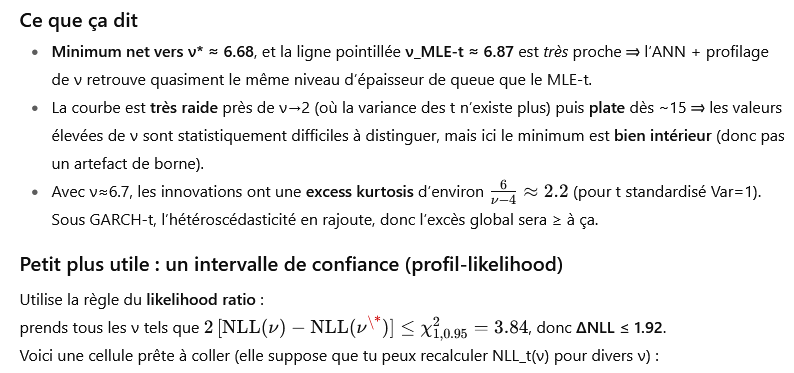

In [ ]:
# 95% CI pour ν par profil de vraisemblance (ΔNLL ≤ 1.92)
import numpy as np
from math import lgamma, log, pi

def nll_student_t_full(params, x, nu):
    a0,a1,b1 = float(params["alpha0"]), float(params["alpha1"]), float(params["beta1"])
    if not (a0>0 and 0<=a1<1 and 0<=b1<1 and a1+b1<1 and nu>2): return np.inf
    T=len(x); h=np.empty(T); v0=np.var(x); h[0]=v0 if v0>1e-18 else 1e-6
    for t in range(1,T):
        h[t]=a0+a1*x[t-1]**2+b1*h[t-1]
        if not np.isfinite(h[t]) or h[t]<=1e-18: return np.inf
    e=x/np.sqrt(h)
    const=lgamma((nu+1)/2)-lgamma(nu/2)-0.5*np.log((nu-2)*np.pi)
    ll=np.sum(const - 0.5*np.log(h) - ((nu+1)/2)*np.log(1+(e**2)/(nu-2)))
    return float(-ll)

nu_grid = np.linspace(2.2, 30, 300)
nlls = np.array([nll_student_t_full(params_ann_dict, rets, nu) for nu in nu_grid])
nu_star = nu_grid[np.argmin(nlls)]
thr = np.min(nlls) + 1.92   # 95% CI: ΔNLL <= 1.92
mask = nlls <= thr
ci = (nu_grid[mask][0], nu_grid[mask][-1])
print(f"nu* ≈ {nu_star:.3f}, 95% CI ≈ [{ci[0]:.2f}, {ci[1]:.2f}]")


## 2D heatmap NLL-t over (nu, mu) around ANN

Min grille: ν*=6.86, μ*=0.9709, NLL=-33719.1


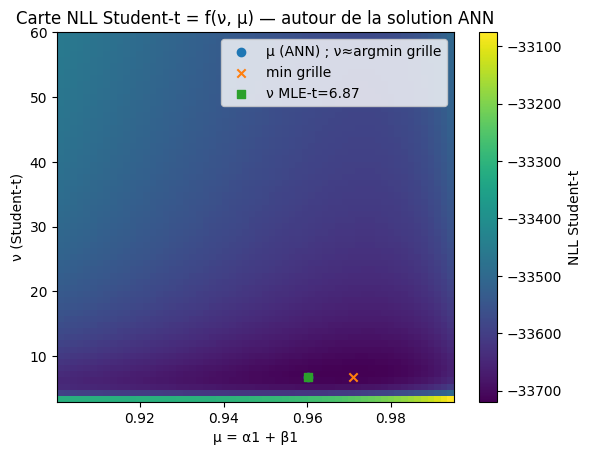

In [14]:
# === Heatmap NLL Student-t = f(ν, μ) — version robuste ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import lgamma, log, pi

# -- Prérequis
assert 'rets' in globals(), "rets manquant : exécute la cellule de chargement des données."
assert 'params_ann_dict' in globals(), "params_ann_dict manquant : exécute la calibration ANN."

def nll_student_t_under_params(params, x, nu):
    a0, a1, b1 = float(params["alpha0"]), float(params["alpha1"]), float(params["beta1"])
    if not (a0 > 0 and 0 <= a1 < 1 and 0 <= b1 < 1 and a1 + b1 < 1 and nu > 2):
        return np.inf
    T = len(x); h = np.empty(T, dtype=float)
    v0 = np.var(x); h[0] = v0 if v0 > 1e-18 else 1e-6
    for t in range(1, T):
        h[t] = a0 + a1 * x[t-1]**2 + b1 * h[t-1]
        if not np.isfinite(h[t]) or h[t] <= 1e-18: return np.inf
    e = x / np.sqrt(h)
    const = lgamma((nu + 1.0) / 2.0) - lgamma(nu / 2.0) - 0.5 * log((nu - 2.0) * pi)
    ll = np.sum(const - 0.5*np.log(h) - ((nu + 1.0)/2.0) * np.log(1.0 + (e**2)/(nu - 2.0)))
    return float(-ll)

sigma2_emp = float(np.var(rets))
alpha1_base = float(params_ann_dict["alpha1"])
mu_center = float(params_ann_dict["alpha1"] + params_ann_dict["beta1"])
# si mu_hat existe, on l'utilise comme centre
if 'mu_hat' in globals():
    try:
        mu_center = float(mu_hat)
    except Exception:
        pass

# -- Grille
nu_min, nu_max, nu_points = 3.0, 60.0, 60
mu_halfwidth = 0.06
mu_min = max(alpha1_base + 1e-4, mu_center - mu_halfwidth)
mu_max = min(0.995,           mu_center + mu_halfwidth)
mu_points = 60

nus = np.linspace(nu_min, nu_max, nu_points)
mus = np.linspace(mu_min, mu_max, mu_points)
nll_grid = np.empty((nu_points, mu_points), dtype=float)

for i, nu in enumerate(nus):
    for j, mu in enumerate(mus):
        beta1 = float(np.clip(mu - alpha1_base, 0.0, 0.995 - alpha1_base))
        alpha0 = float(max(1e-18, sigma2_emp * (1.0 - alpha1_base - beta1)))
        params_ij = {"alpha0": alpha0, "alpha1": alpha1_base, "beta1": beta1}
        nll_grid[i, j] = nll_student_t_under_params(params_ij, rets, nu)

# -- Min de la grille
mi = np.unravel_index(np.nanargmin(nll_grid), nll_grid.shape)
nu_star_grid = float(nus[mi[0]]); mu_star_grid = float(mus[mi[1]]); nll_star_grid = float(nll_grid[mi])
print(f"Min grille: ν*={nu_star_grid:.2f}, μ*={mu_star_grid:.4f}, NLL={nll_star_grid:.1f}")

# -- Plot
plt.figure()
extent = [mus[0], mus[-1], nus[0], nus[-1]]
im = plt.imshow(nll_grid, aspect="auto", origin="lower", extent=extent)
plt.colorbar(im, label="NLL Student-t")

mu_ann = float(params_ann_dict["alpha1"] + params_ann_dict["beta1"])
plt.scatter([mu_ann], [nu_star_grid], label="μ (ANN) ; ν≈argmin grille", marker="o")
plt.scatter([mu_star_grid], [nu_star_grid], label="min grille", marker="x")

# overlay ν_MLE-t si dispo
if 'mle_t_res' in globals() and isinstance(mle_t_res, dict) and 'nu' in mle_t_res:
    plt.scatter([mu_ann], [float(mle_t_res["nu"])], label=f"ν MLE-t={float(mle_t_res['nu']):.2f}", marker="s")

plt.xlabel("μ = α1 + β1"); plt.ylabel("ν (Student-t)")
plt.title("Carte NLL Student-t = f(ν, μ) — autour de la solution ANN")
plt.legend(); plt.show()

# (optionnel) sauvegarde
# pd.DataFrame(nll_grid, index=nus, columns=mus).to_csv("nll_student_t_grid_nu_mu.csv")


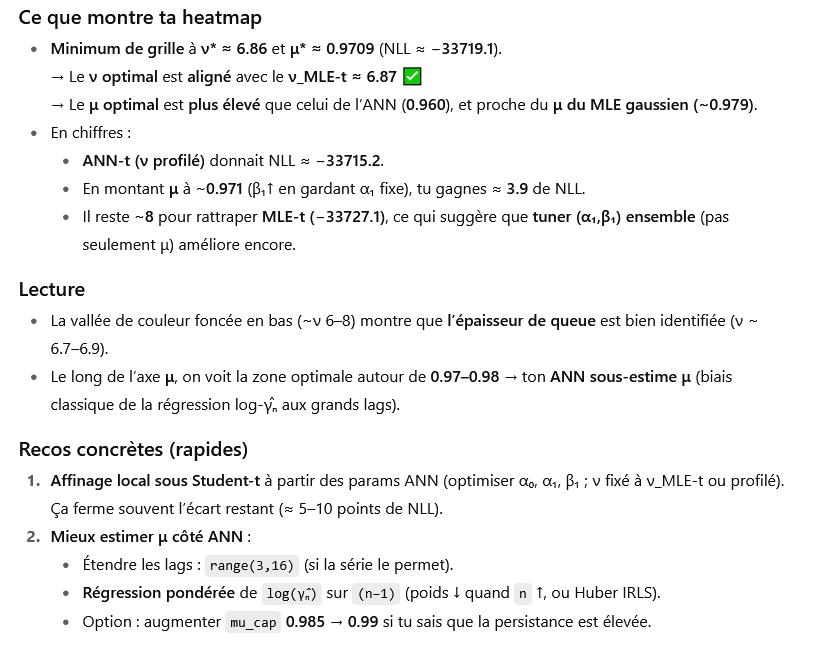

## Affinage local t-NLL depuis l’ANN

In [ ]:
# refine α0, α1, β1 sous Student-t; ν fixé au ν_MLE-t (ou remplace par nu_prof)
from math import log
import numpy as np
try:
    from scipy.optimize import minimize
except Exception as e:
    raise RuntimeError("SciPy requis pour ce raffinage.") from e

def map_theta_to_params(theta):
    w,u,v = theta
    eu, ev = np.exp(u), np.exp(v)
    Z = 1.0 + eu + ev
    return float(np.exp(w)), float(eu/Z), float(ev/Z)

def nll_student_t_full_theta(theta, x, nu):
    a0,a1,b1 = map_theta_to_params(theta)
    if not (a0>0 and 0<=a1<1 and 0<=b1<1 and a1+b1<1): return 1e12
    T=len(x); h=np.empty(T); v0=np.var(x); h[0]=v0 if v0>1e-18 else 1e-6
    for t in range(1,T):
        h[t]=a0+a1*x[t-1]**2+b1*h[t-1]
        if not np.isfinite(h[t]) or h[t]<=1e-18: return 1e12
    e=x/np.sqrt(h)
    from math import lgamma, pi
    const = lgamma((nu+1)/2) - lgamma(nu/2) - 0.5*np.log((nu-2)*np.pi)
    ll = np.sum(const - 0.5*np.log(h) - ((nu+1)/2)*np.log(1 + (e**2)/(nu-2)))
    return float(-ll)

# init: inverser la param pour partir de l’ANN
mu = params_ann_dict["alpha1"] + params_ann_dict["beta1"]
w0 = np.log(max(params_ann_dict["alpha0"], 1e-18))
u0 = np.log(params_ann_dict["alpha1"]/max(1-mu,1e-12))
v0 = np.log(params_ann_dict["beta1"]/max(1-mu,1e-12))

nu_fix = float(mle_t_res["nu"]) if "mle_t_res" in globals() else 6.8
res = minimize(nll_student_t_full_theta, (w0,u0,v0), args=(rets, nu_fix), method="Nelder-Mead",
               options={"maxiter":3000,"xatol":1e-8,"fatol":1e-8,"disp":False})
a0r,a1r,b1r = map_theta_to_params(res.x); nll_ref = res.fun
print({"alpha0":a0r,"alpha1":a1r,"beta1":b1r,"nu":nu_fix,"NLL_refined":nll_ref})


## μ via régression pondérée (WLS) de log(γ̂ₙ)

In [ ]:
# Recalcule mu_hat avec WLS (poids w_n ~ 1/(n-1) ou ~ (T-n))
lags = list(range(3,16))
sigma2_emp, gammahats = multi_gammahats_from_returns(rets, lags)

xs, ys, ws = [], [], []
T = len(rets)
for g,n in zip(gammahats, lags):
    if np.isfinite(g) and g>0:
        xs.append(n-1.0); ys.append(np.log(g))
        ws.append(max(T-n, 1))        # poids décroissant avec le lag
X = np.vstack([np.ones(len(xs)), np.array(xs)]).T
W = np.diag(np.array(ws, dtype=float))
beta = np.linalg.pinv(X.T@W@X) @ (X.T@W@np.array(ys))
mu_wls = float(np.exp(beta[1]))
mu_wls = float(np.clip(mu_wls, 0.0, 0.99))
print("mu_hat (WLS) =", mu_wls)


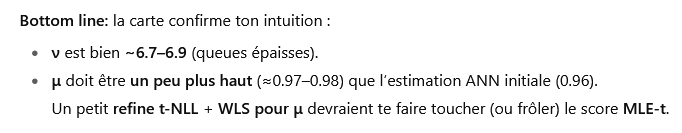